In [392]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['axes.titlesize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text


# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
in_vitro_roi_list = ['dish_roi1','dish_roi2','dish_roi3']
in_vivo_roi_list = ['roi_1','roi_2','roi_3','run2_roi_2','run2_roi_3']
timezero_roi_list = ['timezero_roi_1','timezero_roi_2','timezero_roi_3']

# colors =

In [257]:
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']

for i,in_vitro_roi in enumerate(in_vitro_roi_list):
    # tools.roi_file_paths[in_vitro_roi] = tools.get_roi_file_paths(in_vitro_roi)

    in_vitro_unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[in_vitro_roi]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
    in_vitro_clustered_df = pd.read_csv(f'{tools.roi_file_paths[in_vitro_roi]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.2thresh.csv')
    # merge the clustered and unclustered dataframes
    if i == 0:
        in_vitro_df = in_vitro_unclustered_df.merge(in_vitro_clustered_df[cols_to_keep],on='object_id',how='left') 
        in_vitro_df['roi'] = in_vitro_roi
    else:
        temp_df =  in_vitro_unclustered_df.merge(in_vitro_clustered_df[cols_to_keep],on='object_id',how='left')
        temp_df['roi'] = in_vitro_roi
        # concatenate the dataframes together
        in_vitro_df = pd.concat([in_vitro_df,temp_df],ignore_index=True)

for i, in_vivo_roi in enumerate(in_vivo_roi_list):
    # tools.roi_file_paths[in_vivo_roi] = tools.get_roi_file_paths(in_vivo_roi)
    # load the unclustered and clustered dataframes
    in_vivo_unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[in_vivo_roi]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
    in_vivo_clustered_df = pd.read_csv(f'{tools.roi_file_paths[in_vivo_roi]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')

    # merge the clustered and unclustered dataframes
    if i == 0:
        in_vivo_df = in_vivo_unclustered_df.merge(in_vivo_clustered_df[cols_to_keep],on='object_id',how='left') 
        in_vivo_df['roi'] = in_vivo_roi
    else:
        temp_df =  in_vivo_unclustered_df.merge(in_vivo_clustered_df[cols_to_keep],on='object_id',how='left')
        temp_df['roi'] = in_vivo_roi
        # concatenate the dataframes together
        in_vivo_df = pd.concat([in_vivo_df,temp_df],ignore_index=True)

for i, timezero_roi in enumerate(timezero_roi_list):

    # tools.roi_file_paths[timezero_roi] = tools.get_roi_file_paths(timezero_roi)
    # load the unclustered and clustered dataframes
    timezero_unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[timezero_roi]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
    timezero_clustered_df = pd.read_csv(f'{tools.roi_file_paths[timezero_roi]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')

    # merge the clustered and unclustered dataframes
    if i == 0:
        timezero_df = timezero_unclustered_df.merge(timezero_clustered_df[cols_to_keep],on='object_id',how='left') 
        timezero_df['roi'] = timezero_roi
    else:
        temp_df =  timezero_unclustered_df.merge(timezero_clustered_df[cols_to_keep],on='object_id',how='left')
        temp_df['roi'] = timezero_roi
        # concatenate the dataframes together
        timezero_df = pd.concat([timezero_df,temp_df],ignore_index=True)

# in_vivo_df = in_vivo_unclustered_df.merge(in_vivo_clustered_df[cols_to_keep],on='object_id',how='left')

IN VITRO
0: 0.10878924936940071
1: 0.14514655997216666
2: 0.1597590675828477
3+ 0.5863051230755849
4+ 0.4395711924849961
In vitro mean: 3.6299686874836916
In vitro median: 3.0


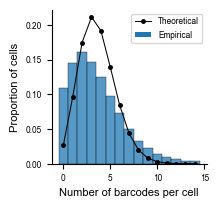

In [265]:
### Plotting distribution of number of barcodes per cell, amongst barcoded cells

min_bcs_per_cell = 3
sns.set_style()

plt.figure(figsize=(2,2))
# plt.suptitle(f'Number of barcodes per cell (threshold={threshold})')
# ax = plt.subplot(1,2,1)
ax = plt.gca()

# plot distribution of number of barcodes (above some threshold) in each cell
sns.histplot((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1),
             bins=range(16),stat='probability',ax=ax,linewidth=0.25)

mean = np.mean((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))

print('IN VITRO')

print('0:',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==0)/len(in_vitro_df))
print('1:',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==1)/len(in_vitro_df))
print('2:',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==2)/len(in_vitro_df))
print('3+',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))>2)/len(in_vitro_df))
print('4+',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))>3)/len(in_vitro_df))

print('In vitro mean:',np.mean((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)))
print('In vitro median:', np.median((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)))

# plot poisson distribution
x = np.arange(0,15)
poisson_dist = scipy.stats.poisson.pmf(x, mean)
plt.plot([i+0.5 for i in x], poisson_dist, color='k',marker='.',lw=0.75,ms=5)
plt.legend(labels=[f'Theoretical','Empirical'])

plt.xlabel('Number of barcodes per cell')
plt.ylabel('Proportion of cells')

plt.xticks(np.arange(0.5,16.5,5),range(0,16,5),)

plt.yticks([0,0.05,0.10,0.15,0.20],[0.00,0.05,0.10,0.15,0.20])
formatter = matplotlib.ticker.FormatStrFormatter('%.2f') 
ax.yaxis.set_major_formatter(formatter)

sns.despine()

plt.savefig('../graphs/in_vitro_barcodes_per_cell.pdf',bbox_inches='tight',transparent=True)

IN VITRO
0: 0.10878924936940071
1: 0.14514655997216666
2: 0.1597590675828477
3+ 0.5863051230755849
4+ 0.4395711924849961
In vitro mean: 3.6299686874836916
In vitro median: 3.0


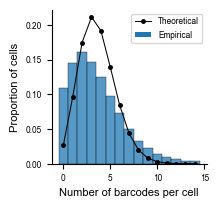

In [277]:
### Plotting distribution of number of barcodes per cell, amongst barcoded cells

min_bcs_per_cell = 3
sns.set_style()

plt.figure(figsize=(2,2))
# plt.suptitle(f'Number of barcodes per cell (threshold={threshold})')
# ax = plt.subplot(1,2,1)
ax = plt.gca()

# plot distribution of number of barcodes (above some threshold) in each cell
sns.histplot((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1),
             bins=range(16),stat='probability',ax=ax,linewidth=0.25)

mean = np.mean((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))

print('IN VITRO')

print('0:',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==0)/len(in_vitro_df))
print('1:',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==1)/len(in_vitro_df))
print('2:',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==2)/len(in_vitro_df))
print('3+',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))>2)/len(in_vitro_df))
print('4+',sum(((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))>3)/len(in_vitro_df))

print('In vitro mean:',np.mean((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)))
print('In vitro median:', np.median((in_vitro_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)))

# plot poisson distribution
x = np.arange(0,15)
poisson_dist = scipy.stats.poisson.pmf(x, mean)
plt.plot([i+0.5 for i in x], poisson_dist, color='k',marker='.',lw=0.75,ms=5)
plt.legend(labels=[f'Theoretical','Empirical'])

plt.xlabel('Number of barcodes per cell')
plt.ylabel('Proportion of cells')

plt.xticks(np.arange(0.5,16.5,5),range(0,16,5),)

plt.yticks([0,0.05,0.10,0.15,0.20],[0.00,0.05,0.10,0.15,0.20])
formatter = matplotlib.ticker.FormatStrFormatter('%.2f') 
ax.yaxis.set_major_formatter(formatter)

sns.despine()

plt.savefig('../graphs/in_vitro_barcodes_per_cell_figure1.pdf',bbox_inches='tight',transparent=True)

IN VITRO
0: 0.3032057627971084
1: 0.1775981766846091
2: 0.1705411057669352
3+ 0.3486549547513473
4+ 0.21327506024134738
In vivo mean: 2.017364150589044
In vivo median: 2.0


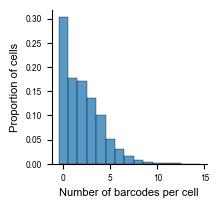

In [266]:
### Plotting distribution of number of barcodes per cell, amongst barcoded cells

min_bcs_per_cell = 3



df_here = in_vivo_df

sns.set_style()

plt.figure(figsize=(2,2))
# plt.suptitle(f'Number of barcodes per cell (threshold={threshold})')
# ax = plt.subplot(1,2,1)
ax = plt.gca()

# plot distribution of number of barcodes (above some threshold) in each cell
sns.histplot((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1),
             bins=range(16),stat='probability',ax=ax,linewidth=0.25)

mean = np.mean((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))

print('IN VITRO')

print('0:',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==0)/len(df_here))
print('1:',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==1)/len(df_here))
print('2:',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==2)/len(df_here))
print('3+',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))>2)/len(df_here))
print('4+',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))>3)/len(df_here))

print('In vivo mean:',np.mean((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)))
print('In vivo median:', np.median((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)))

# plot poisson distribution
# x = np.arange(0,15)
# poisson_dist = scipy.stats.poisson.pmf(x, mean)
# plt.plot([i+0.5 for i in x], poisson_dist, color='k',marker='.',lw=0.75,ms=5)
# plt.legend(labels=[f'Theoretical','Empirical'])

plt.xlabel('Number of barcodes per cell')
plt.ylabel('Proportion of cells')

plt.xticks(np.arange(0.5,16.5,5),range(0,16,5),)

plt.yticks([0,0.05,0.10,0.15,0.20,0.25,0.3],[0.00,0.05,0.10,0.15,0.20,0.25,0.3])
formatter = matplotlib.ticker.FormatStrFormatter('%.2f') 
ax.yaxis.set_major_formatter(formatter)

sns.despine()

plt.savefig('../graphs/in_vivo_barcodes_per_cell.pdf',bbox_inches='tight',transparent=True)

In [302]:
dataset_counts

0         0
1         1
2         0
3         0
4         0
         ..
314148    0
314149    4
314150    4
314151    1
314152    3
Length: 314153, dtype: int64

In vitro
0: 0.10878924936940071
1: 0.14514655997216666
2: 0.1597590675828477
3+ 0.5863051230755849
4+ 0.4395711924849961
Mean: 3.6299686874836916
Median: 3.0
In vivo pre-injection
0: 0.10894781450538805
1: 0.16585543043952053
2: 0.171909432134641
3+ 0.5532873229204505
4+ 0.39782055938975663
Mean: 3.3795132582637124
Median: 3.0
In vivo
0: 0.3032057627971084
1: 0.1775981766846091
2: 0.1705411057669352
3+ 0.3486549547513473
4+ 0.21327506024134738
Mean: 2.017364150589044
Median: 2.0
Mean barcodes per barcoded cell: 4.073075515432476
Mean barcodes per barcoded cell: 3.7927220350038047
Mean barcodes per barcoded cell: 2.895207857469164


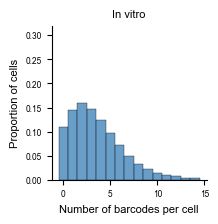

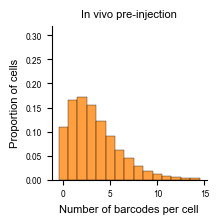

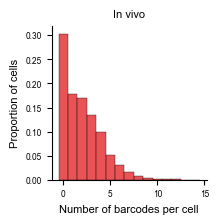

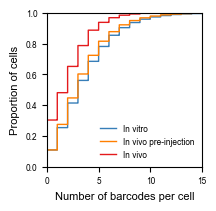

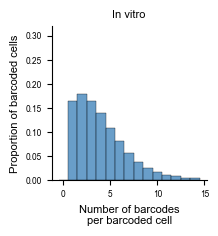

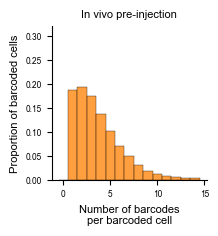

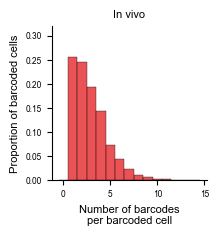

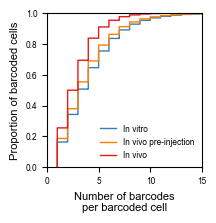

In [393]:
labels = ['In vitro','In vivo pre-injection','In vivo']
datasets = [in_vitro_df,timezero_df,in_vivo_df]
colors = ['#377eb8','#ff7f00','#e41a1c']

for d,dataset in enumerate(datasets):

    df_here = dataset

    sns.set_style()

    plt.figure(figsize=(2,2))
    # plt.suptitle(f'Number of barcodes per cell (threshold={threshold})')
    # ax = plt.subplot(1,2,1)
    ax = plt.gca()

    # plot distribution of number of barcodes (above some threshold) in each cell
    sns.histplot((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1),
                bins=range(16),stat='probability',ax=ax,linewidth=0.25,color=colors[d])

    mean = np.mean((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))

    print(f'{labels[d]}')

    print('0:',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==0)/len(df_here))
    print('1:',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==1)/len(df_here))
    print('2:',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))==2)/len(df_here))
    print('3+',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))>2)/len(df_here))
    print('4+',sum(((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1))>3)/len(df_here))

    print('Mean:',np.mean((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)))
    print('Median:', np.median((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)))

    plt.xlabel('Number of barcodes per cell')
    plt.ylabel('Proportion of cells')

    plt.title(f"{labels[d]}")

    plt.xticks(np.arange(0.5,16.5,5),range(0,16,5),)

    plt.yticks([0,0.05,0.10,0.15,0.20,0.25,0.3],[0.00,0.05,0.10,0.15,0.20,0.25,0.3])
    formatter = matplotlib.ticker.FormatStrFormatter('%.2f') 
    ax.yaxis.set_major_formatter(formatter)

    plt.ylim(0,0.32)

    sns.despine()

    plt.savefig(f'../graphs/{labels[d]}_barcodes_per_cell.pdf',bbox_inches='tight',transparent=True)


plt.figure(figsize=(2,2))
for d,dataset in enumerate([in_vitro_df,timezero_df,in_vivo_df]):
    df_here = dataset
    sns.ecdfplot((df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1),
                 stat='proportion',linewidth=1,label=labels[d],color=colors[d])
    plt.legend(frameon=False)

    plt.xlabel('Number of barcodes per cell')
    plt.ylabel('Proportion of cells')

    plt.xticks(np.arange(0,21,5),range(0,21,5),)
    plt.xlim(0,15)
    plt.savefig(f'../graphs/barcodes_per_cell_ecdf.pdf',bbox_inches='tight',transparent=True)

# exclude non-barcoded cells for fairer comparison between in vitro and in vivo
for d,dataset in enumerate(datasets):

    df_here = dataset

    dataset_counts = (df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)
    dataset_counts_masked = np.ma.masked_where(dataset_counts  == 0, dataset_counts)

    sns.set_style()

    plt.figure(figsize=(2,2))
    ax = plt.gca()

    # plot distribution of number of barcodes (above some threshold) in each cell
    sns.histplot(dataset_counts_masked,
                bins=range(16),stat='probability',ax=ax,linewidth=0.25,color=colors[d])


    plt.xlabel('Number of barcodes\nper barcoded cell')
    plt.ylabel('Proportion of barcoded cells')
    plt.xticks(np.arange(0.5,16.5,5),range(0,16,5),)

    plt.title(f"{labels[d]}")

    print('Mean barcodes per barcoded cell:',np.mean(dataset_counts_masked))
    

    plt.yticks([0,0.05,0.10,0.15,0.20,0.25,0.3],[0.00,0.05,0.10,0.15,0.20,0.25,0.3])
    formatter = matplotlib.ticker.FormatStrFormatter('%.2f') 
    ax.yaxis.set_major_formatter(formatter)

    plt.ylim(0,0.32)

    sns.despine()

    plt.savefig(f'../graphs/{labels[d]}_barcodes_per_barcodedcell.pdf',bbox_inches='tight',transparent=True)
        
plt.figure(figsize=(2,2))
for d,dataset in enumerate([in_vitro_df,timezero_df,in_vivo_df]):
    df_here = dataset

    dataset_counts = (df_here[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)
    dataset_counts_masked = np.ma.masked_where(dataset_counts  == 0, dataset_counts)

    sns.ecdfplot(dataset_counts_masked,
                 stat='proportion',linewidth=1,label=labels[d],color=colors[d])
    plt.legend(frameon=False)
    plt.xticks(np.arange(0,21,5),range(0,21,5),)
    plt.xlim(0,15)

    plt.xlabel('Number of barcodes\nper barcoded cell')
    plt.ylabel('Proportion of barcoded cells')


    plt.savefig(f'../graphs/barcodes_per_barcodedcell_ecdf.pdf',bbox_inches='tight',transparent=True)


Linear regression slope: 0.41, intercept: 0.02


(0.0, 2.5)

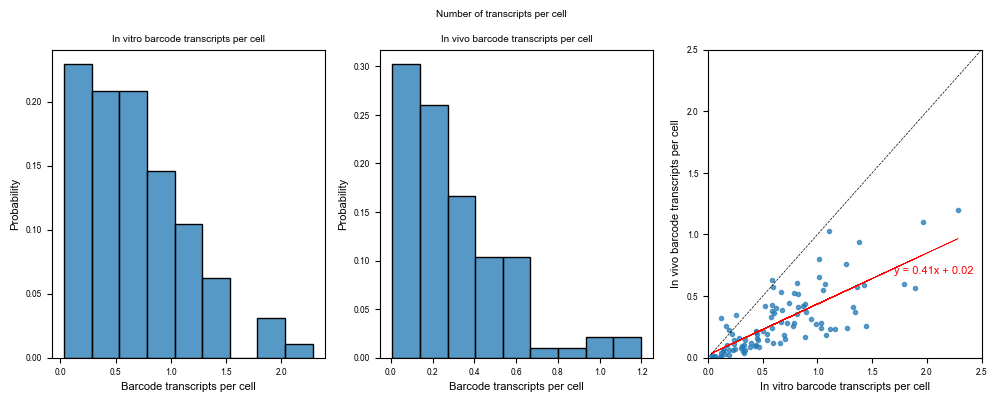

In [156]:
# ok so there are slightly different distributions of barcodes per cell in vitro and in vivo
# however, we also know that the number of transcripts per cell is different between these settings:

plt.figure(figsize=(12,4))
plt.suptitle('Number of transcripts per cell')
ax = plt.subplot(1,3,1)
plt.title('In vitro barcode transcripts per cell')
sns.histplot(in_vitro_df[tools.barcode_cols].sum(axis=0)/len(in_vitro_df.index),stat='probability',ax=ax)
plt.xlabel('Barcode transcripts per cell')

ax = plt.subplot(1,3,2)
plt.title('In vivo barcode transcripts per cell')
sns.histplot(in_vivo_df[tools.barcode_cols].sum(axis=0)/len(in_vivo_df.index),stat='probability',ax=ax)
plt.xlabel('Barcode transcripts per cell')

ax = plt.subplot(1,3,3)
plt.scatter((in_vitro_df[tools.barcode_cols].sum(axis=0)/len(in_vitro_df.index)),
            (in_vivo_df[tools.barcode_cols].sum(axis=0)/len(in_vivo_df.index)),
            marker='.',alpha=0.7)
plt.xlabel('In vitro barcode transcripts per cell')
plt.ylabel('In vivo barcode transcripts per cell')

# fit a line to the scatter plot
from sklearn.linear_model import LinearRegression
X = (in_vitro_df[tools.barcode_cols].sum(axis=0)/len(in_vitro_df.index)).values.reshape(-1, 1)
y = (in_vivo_df[tools.barcode_cols].sum(axis=0)/len(in_vivo_df.index)).values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
plt.plot(X, model.predict(X), color='red', linewidth=0.5)
print(f'Linear regression slope: {model.coef_[0][0]:.2f}, intercept: {model.intercept_[0]:.2f}')
plt.annotate('y = {:.2f}x + {:.2f}'.format(model.coef_[0][0], model.intercept_[0]),
             xy=(0.97, 0.3), xycoords='axes fraction', fontsize=8, color='red',
             ha='right', va='top')

plt.plot([0,2.5], [0,2.5], color='black', linestyle='--', linewidth=0.5)


plt.xlim(0,2.5)
plt.ylim(0,2.5)


<AxesSubplot: xlabel='bc_cluster_n_bcs', ylabel='Probability'>

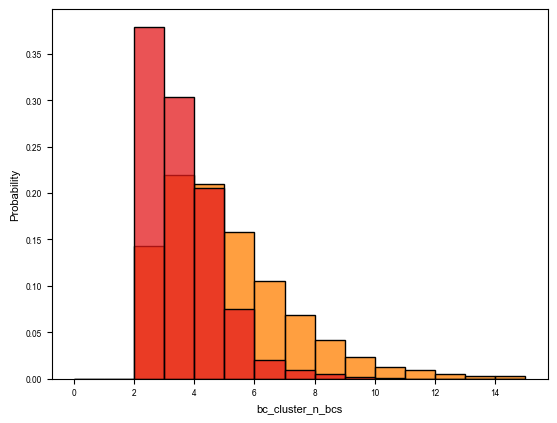

In [332]:
# sns.histplot(in_vitro_df['bc_cluster_n_bcs'],color=colors[0],stat='probability',label='In vitro',bins=range(16))
sns.histplot(timezero_df[timezero_df['bc_cluster_n_bcs']>1]['bc_cluster_n_bcs'],color=colors[1],stat='probability',label='In vitro',bins=range(16))
sns.histplot(in_vivo_df[in_vivo_df['bc_cluster_n_bcs']>1]['bc_cluster_n_bcs'],color=colors[2],stat='probability',label='In vitro',bins=range(16))

In [172]:
filtered_in_vitro_df/len(filtered_in_vitro_df)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., 8.697921196833956e-05, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False,  True,  True]],
  fill_value=1e+20)

In [175]:
filtered_in_vitro_df = np.ma.masked_where((in_vitro_df[tools.barcode_cols].values) < min_bcs_per_cell, in_vitro_df[tools.barcode_cols].values)
filtered_in_vitro_df/len(filtered_in_vitro_df)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., 8.697921196833956e-05, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False,  True,  True]],
  fill_value=1e+20)

In [ ]:
sns.histplot(filtered_in_vitro_df/len(filtered_in_vitro_df))

Linear regression slope: 0.52, intercept: 3.84


Text(0.97, 0.3, 'y = 0.52x + 3.84')

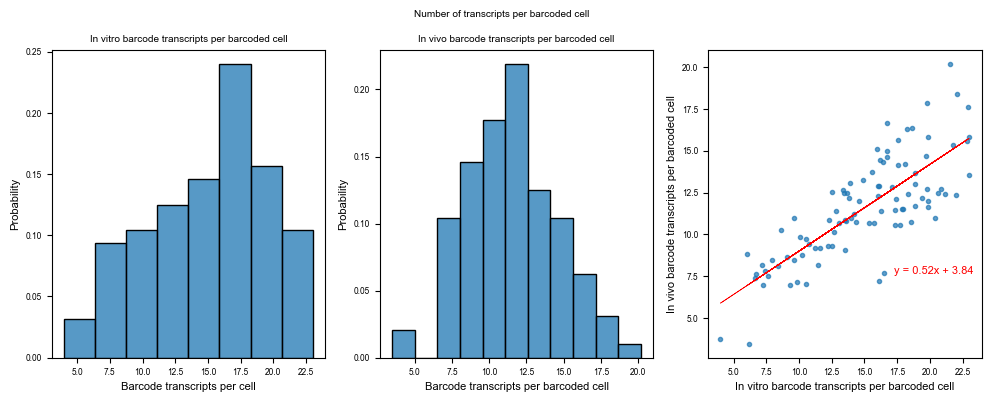

In [310]:
## what if we do this only for cells in which there are greater than 2 transcripts? This adjusts for mouse cells

min_bcs_per_cell = 3

filtered_in_vitro_df = np.ma.masked_where(in_vitro_df[tools.barcode_cols].values < min_bcs_per_cell, in_vitro_df[tools.barcode_cols].values)
filtered_in_vivo_df = np.ma.masked_where(in_vivo_df[tools.barcode_cols].values < min_bcs_per_cell, in_vivo_df[tools.barcode_cols].values)

plt.figure(figsize=(12,4))
plt.suptitle('Number of transcripts per barcoded cell')
ax = plt.subplot(1,3,1)
plt.title('In vitro barcode transcripts per barcoded cell')
sns.histplot(np.mean(filtered_in_vitro_df,axis=0),stat='probability',ax=ax)
plt.xlabel('Barcode transcripts per cell')

ax = plt.subplot(1,3,2)
plt.title('In vivo barcode transcripts per barcoded cell')
sns.histplot(np.mean(filtered_in_vivo_df,axis=0),stat='probability',ax=ax)
plt.xlabel('Barcode transcripts per barcoded cell')

ax = plt.subplot(1,3,3)
plt.scatter(np.mean(filtered_in_vitro_df,axis=0),
            np.mean(filtered_in_vivo_df,axis=0),
            marker='.',alpha=0.7)
plt.xlabel('In vitro barcode transcripts per barcoded cell')
plt.ylabel('In vivo barcode transcripts per barcoded cell')

# fit a line to the scatter plot
from sklearn.linear_model import LinearRegression
X = (np.mean(filtered_in_vitro_df,axis=0)).reshape(-1, 1)
y = (np.mean(filtered_in_vivo_df,axis=0)).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
plt.plot(X, model.predict(X), color='red', linewidth=0.5)
print(f'Linear regression slope: {model.coef_[0][0]:.2f}, intercept: {model.intercept_[0]:.2f}')
plt.annotate('y = {:.2f}x + {:.2f}'.format(model.coef_[0][0], model.intercept_[0]),
             xy=(0.97, 0.3), xycoords='axes fraction', fontsize=8, color='red',
             ha='right', va='top')

# plt.plot([10,30], [10,30], color='black', linestyle='--', linewidth=0.5)


# plt.xlim(0,2.5)
# plt.ylim(0,2.5)


In [352]:
# import pandas as pd
# import numpy as np

# def downsample_transcripts(df, target_total, method='multinomial', random_state=None):
#     """
#     Downsample transcript counts while preserving relative distribution across cells.
#     Controls column totals (transcript totals) rather than row totals (cell totals).
    
#     Parameters:
#     -----------
#     df : pandas.DataFrame
#         DataFrame where rows are cells and columns are transcripts
#     target_total : int or array-like
#         Target total number of transcripts after downsampling.
#         If int: same target for all transcripts (columns)
#         If array-like: target for each transcript (must match number of columns)
#     method : str, default 'multinomial'
#         Method for downsampling ('multinomial' or 'proportional')
#     random_state : int, optional
#         Random seed for reproducibility
        
#     Returns:
#     --------
#     pandas.DataFrame
#         Downsampled DataFrame with same structure as input
#     """
    
#     if random_state is not None:
#         np.random.seed(random_state)
    
#     # Handle target_total as array or scalar
#     if np.isscalar(target_total):
#         target_totals = np.full(len(df.columns), target_total)
#     else:
#         target_totals = np.array(target_total)
#         if len(target_totals) != len(df.columns):
#             raise ValueError(f"Length of target_total array ({len(target_totals)}) must match number of columns ({len(df.columns)})")
    
#     # Get current totals for each transcript (column)
#     current_totals = df.sum(axis=0).values
    
#     # Initialize result array
#     downsampled_array = np.zeros_like(df.values, dtype=int)
    
#     # Process each transcript (column) individually
#     for j in range(len(df.columns)):
#         current_transcript_total = current_totals[j]
#         target_transcript_total = target_totals[j]
        
#         # Skip if target is greater than or equal to current
#         if target_transcript_total >= current_transcript_total:
#             print(f"Transcript {df.columns[j]}: Target ({target_transcript_total}) >= current ({current_transcript_total}). Keeping original counts.")
#             downsampled_array[:, j] = df.iloc[:, j].values
#             continue
        
#         # Skip if current total is 0
#         if current_transcript_total == 0:
#             print(f"Transcript {df.columns[j]}: No counts to downsample.")
#             downsampled_array[:, j] = df.iloc[:, j].values
#             continue
        
#         transcript_counts = df.iloc[:, j].values
        
#         if method == 'multinomial':
#             # Create probability vector for this transcript across cells
#             probabilities = transcript_counts / current_transcript_total
            
#             # Sample from multinomial distribution
#             downsampled_array[:, j] = np.random.multinomial(target_transcript_total, probabilities)
            
#         elif method == 'proportional':
#             # Simple proportional scaling with rounding
#             scaling_factor = target_transcript_total / current_transcript_total
#             downsampled_transcript = np.round(transcript_counts * scaling_factor).astype(int)
            
#             # Adjust for rounding errors
#             current_sum = downsampled_transcript.sum()
#             difference = target_transcript_total - current_sum
            
#             if difference != 0:
#                 # Add/subtract counts randomly to match target
#                 nonzero_indices = np.where(transcript_counts > 0)[0]
#                 if len(nonzero_indices) > 0:
#                     probabilities = transcript_counts[nonzero_indices] / current_transcript_total
                    
#                     for _ in range(abs(difference)):
#                         if difference > 0:
#                             # Add a count
#                             idx = np.random.choice(nonzero_indices, p=probabilities)
#                             downsampled_transcript[idx] += 1
#                         else:
#                             # Remove a count (but don't go below 0)
#                             valid_indices = nonzero_indices[downsampled_transcript[nonzero_indices] > 0]
#                             if len(valid_indices) > 0:
#                                 valid_probs = probabilities[np.isin(nonzero_indices, valid_indices)]
#                                 valid_probs = valid_probs / valid_probs.sum()
#                                 idx = np.random.choice(valid_indices, p=valid_probs)
#                                 downsampled_transcript[idx] = max(0, downsampled_transcript[idx] - 1)
            
#             downsampled_array[:, j] = downsampled_transcript
            
#         else:
#             raise ValueError("Method must be 'multinomial' or 'proportional'")
    
#     # Create new dataframe with same structure
#     result_df = pd.DataFrame(
#         downsampled_array,
#         index=df.index,
#         columns=df.columns
#     )
    
#     return result_df

# # Updated validation function
# def validate_downsampling(original_df, downsampled_df, target_total, tolerance=0.01):
#     """
#     Validate that downsampling preserved relative distributions across cells for each transcript
#     """
#     # Handle target_total as array or scalar
#     if np.isscalar(target_total):
#         target_totals = np.full(len(original_df.columns), target_total)
#     else:
#         target_totals = np.array(target_total)
    
#     # Check totals for each transcript (column)
#     actual_totals = downsampled_df.sum(axis=0).values
#     print("Transcript-wise totals comparison:")
#     for j in range(min(10, len(target_totals))):  # Show first 10 transcripts
#         transcript_name = original_df.columns[j]
#         print(f"  {transcript_name}: Target={target_totals[j]}, Actual={actual_totals[j]}")
#     if len(target_totals) > 10:
#         print(f"  ... and {len(target_totals) - 10} more transcripts")
    
#     # Check that proportions within each transcript across cells are preserved
#     max_differences = []
#     for j in range(len(original_df.columns)):
#         if original_df.iloc[:, j].sum() > 0:
#             original_props = original_df.iloc[:, j] / original_df.iloc[:, j].sum()
#             if downsampled_df.iloc[:, j].sum() > 0:
#                 downsampled_props = downsampled_df.iloc[:, j] / downsampled_df.iloc[:, j].sum()
#                 max_diff = np.max(np.abs(original_props - downsampled_props))
#                 max_differences.append(max_diff)
    
#     overall_max_diff = np.max(max_differences) if max_differences else 0
#     print(f"Max difference in transcript distribution across cells: {overall_max_diff:.6f}")
#     print(f"Mean difference in transcript distribution across cells: {np.mean(max_differences):.6f}")
    
#     # Also show how total transcript counts changed
#     print(f"\nOverall statistics:")
#     print(f"Original total transcripts: {original_df.sum().sum()}")
#     print(f"Downsampled total transcripts: {downsampled_df.sum().sum()}")
#     print(f"Target total transcripts: {np.sum(target_totals)}")
    
#     return overall_max_diff < tolerance

# # Convenience function to generate common target patterns for transcripts
# def generate_target_totals(n_transcripts, pattern='uniform', **kwargs):
#     """
#     Generate target totals for different common patterns
    
#     Parameters:
#     -----------
#     n_transcripts : int
#         Number of transcripts
#     pattern : str
#         'uniform': same target for all transcripts
#         'normal': normally distributed targets
#         'range': linearly spaced targets
#         'proportional': proportional to current totals
#     **kwargs : additional arguments for each pattern
    
#     Returns:
#     --------
#     numpy.array
#         Array of target totals
#     """
#     if pattern == 'uniform':
#         target = kwargs.get('target', 1000)
#         return np.full(n_transcripts, target)
    
#     elif pattern == 'normal':
#         mean = kwargs.get('mean', 1000)
#         std = kwargs.get('std', 200)
#         targets = np.random.normal(mean, std, n_transcripts)
#         return np.maximum(targets, 0).astype(int)  # Ensure non-negative
    
#     elif pattern == 'range':
#         min_target = kwargs.get('min_target', 500)
#         max_target = kwargs.get('max_target', 1500)
#         return np.linspace(min_target, max_target, n_transcripts, dtype=int)
    
#     elif pattern == 'proportional':
#         current_df = kwargs.get('current_df')
#         if current_df is None:
#             raise ValueError("Must provide 'current_df' for proportional pattern")
#         scaling_factor = kwargs.get('scaling_factor', 0.5)
#         current_totals = current_df.sum(axis=0).values
#         return (current_totals * scaling_factor).astype(int)
    
#     else:
#         raise ValueError("Pattern must be 'uniform', 'normal', 'range', or 'proportional'")

import numpy as np

def downsample_transcripts(data, target_total, method='multinomial', random_state=None):
    """
    Downsample transcript counts while preserving relative distribution across cells.
    Controls column totals (transcript totals) rather than row totals (cell totals).
    
    Parameters:
    -----------
    data : numpy.ndarray
        2D array where rows are cells and columns are transcripts
    target_total : int or array-like
        Target total number of transcripts after downsampling.
        If int: same target for all transcripts (columns)
        If array-like: target for each transcript (must match number of columns)
    method : str, default 'multinomial'
        Method for downsampling ('multinomial' or 'proportional')
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    numpy.ndarray
        Downsampled array with same shape as input
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    
    # Ensure input is numpy array
    data = np.asarray(data)
    
    # Handle target_total as array or scalar
    if np.isscalar(target_total):
        target_totals = np.full(data.shape[1], target_total)
    else:
        target_totals = np.array(target_total)
        if len(target_totals) != data.shape[1]:
            raise ValueError(f"Length of target_total array ({len(target_totals)}) must match number of columns ({data.shape[1]})")
    
    # Get current totals for each transcript (column)
    current_totals = data.sum(axis=0)
    
    # Initialize result array
    downsampled_array = np.zeros_like(data, dtype=int)
    
    # Process each transcript (column) individually
    for j in range(data.shape[1]):
        current_transcript_total = current_totals[j]
        target_transcript_total = target_totals[j]
        
        # Skip if target is greater than or equal to current
        if target_transcript_total >= current_transcript_total:
            print(f"Column {j}: Target ({target_transcript_total}) >= current ({current_transcript_total}). Keeping original counts.")
            downsampled_array[:, j] = data[:, j]
            continue
        
        # Skip if current total is 0
        if current_transcript_total == 0:
            print(f"Column {j}: No counts to downsample.")
            downsampled_array[:, j] = data[:, j]
            continue
        
        transcript_counts = data[:, j]
        
        if method == 'multinomial':
            # Create probability vector for this transcript across cells
            probabilities = transcript_counts / current_transcript_total
            
            # Sample from multinomial distribution
            downsampled_array[:, j] = np.random.multinomial(target_transcript_total, probabilities)
            
        elif method == 'proportional':
            # Simple proportional scaling with rounding
            scaling_factor = target_transcript_total / current_transcript_total
            downsampled_transcript = np.round(transcript_counts * scaling_factor).astype(int)
            
            # Adjust for rounding errors
            current_sum = downsampled_transcript.sum()
            difference = target_transcript_total - current_sum
            
            if difference != 0:
                # Add/subtract counts randomly to match target
                nonzero_indices = np.where(transcript_counts > 0)[0]
                if len(nonzero_indices) > 0:
                    probabilities = transcript_counts[nonzero_indices] / current_transcript_total
                    
                    for _ in range(abs(difference)):
                        if difference > 0:
                            # Add a count
                            idx = np.random.choice(nonzero_indices, p=probabilities)
                            downsampled_transcript[idx] += 1
                        else:
                            # Remove a count (but don't go below 0)
                            valid_indices = nonzero_indices[downsampled_transcript[nonzero_indices] > 0]
                            if len(valid_indices) > 0:
                                valid_probs = probabilities[np.isin(nonzero_indices, valid_indices)]
                                valid_probs = valid_probs / valid_probs.sum()
                                idx = np.random.choice(valid_indices, p=valid_probs)
                                downsampled_transcript[idx] = max(0, downsampled_transcript[idx] - 1)
            
            downsampled_array[:, j] = downsampled_transcript
            
        else:
            raise ValueError("Method must be 'multinomial' or 'proportional'")
    
    return downsampled_array

# Updated validation function for numpy arrays
def validate_downsampling(original_data, downsampled_data, target_total, tolerance=0.01):
    """
    Validate that downsampling preserved relative distributions across cells for each transcript
    """
    # Ensure inputs are numpy arrays
    original_data = np.asarray(original_data)
    downsampled_data = np.asarray(downsampled_data)
    
    # Handle target_total as array or scalar
    if np.isscalar(target_total):
        target_totals = np.full(original_data.shape[1], target_total)
    else:
        target_totals = np.array(target_total)
    
    # Check totals for each transcript (column)
    actual_totals = downsampled_data.sum(axis=0)
    print("Transcript-wise totals comparison:")
    for j in range(min(10, len(target_totals))):  # Show first 10 transcripts
        print(f"  Column {j}: Target={target_totals[j]}, Actual={actual_totals[j]}")
    if len(target_totals) > 10:
        print(f"  ... and {len(target_totals) - 10} more transcripts")
    
    # Check that proportions within each transcript across cells are preserved
    max_differences = []
    for j in range(original_data.shape[1]):
        if original_data[:, j].sum() > 0:
            original_props = original_data[:, j] / original_data[:, j].sum()
            if downsampled_data[:, j].sum() > 0:
                downsampled_props = downsampled_data[:, j] / downsampled_data[:, j].sum()
                max_diff = np.max(np.abs(original_props - downsampled_props))
                max_differences.append(max_diff)
    
    overall_max_diff = np.max(max_differences) if max_differences else 0
    print(f"Max difference in transcript distribution across cells: {overall_max_diff:.6f}")
    print(f"Mean difference in transcript distribution across cells: {np.mean(max_differences):.6f}")
    
    # Also show how total transcript counts changed
    print(f"\nOverall statistics:")
    print(f"Original total transcripts: {original_data.sum()}")
    print(f"Downsampled total transcripts: {downsampled_data.sum()}")
    print(f"Target total transcripts: {np.sum(target_totals)}")
    
    return overall_max_diff < tolerance

# Convenience function to generate common target patterns for transcripts
def generate_target_totals(n_transcripts, pattern='uniform', **kwargs):
    """
    Generate target totals for different common patterns
    
    Parameters:
    -----------
    n_transcripts : int
        Number of transcripts
    pattern : str
        'uniform': same target for all transcripts
        'normal': normally distributed targets
        'range': linearly spaced targets
        'proportional': proportional to current totals
    **kwargs : additional arguments for each pattern
    
    Returns:
    --------
    numpy.array
        Array of target totals
    """
    if pattern == 'uniform':
        target = kwargs.get('target', 1000)
        return np.full(n_transcripts, target)
    
    elif pattern == 'normal':
        mean = kwargs.get('mean', 1000)
        std = kwargs.get('std', 200)
        targets = np.random.normal(mean, std, n_transcripts)
        return np.maximum(targets, 0).astype(int)  # Ensure non-negative
    
    elif pattern == 'range':
        min_target = kwargs.get('min_target', 500)
        max_target = kwargs.get('max_target', 1500)
        return np.linspace(min_target, max_target, n_transcripts, dtype=int)
    
    elif pattern == 'proportional':
        current_data = kwargs.get('current_data')
        if current_data is None:
            raise ValueError("Must provide 'current_data' for proportional pattern")
        scaling_factor = kwargs.get('scaling_factor', 0.5)
        current_totals = np.asarray(current_data).sum(axis=0)
        return (current_totals * scaling_factor).astype(int)
    
    else:
        raise ValueError("Pattern must be 'uniform', 'normal', 'range', or 'proportional'")

# Optimized version using vectorized operations (faster for large arrays)
def downsample_transcripts_vectorized(data, target_total, method='multinomial', random_state=None):
    """
    Vectorized version for better performance with large arrays.
    Only supports multinomial method for now.
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    
    data = np.asarray(data)
    
    if np.isscalar(target_total):
        target_totals = np.full(data.shape[1], target_total)
    else:
        target_totals = np.array(target_total)
        if len(target_totals) != data.shape[1]:
            raise ValueError(f"Length of target_total array ({len(target_totals)}) must match number of columns ({data.shape[1]})")
    
    if method != 'multinomial':
        raise NotImplementedError("Vectorized version only supports multinomial method")
    
    current_totals = data.sum(axis=0)
    downsampled_array = np.zeros_like(data, dtype=int)
    
    # Process all columns at once where possible
    valid_cols = (target_totals < current_totals) & (current_totals > 0)
    
    for j in np.where(valid_cols)[0]:
        probabilities = data[:, j] / current_totals[j]
        downsampled_array[:, j] = np.random.multinomial(target_totals[j], probabilities)
    
    # Handle edge cases
    unchanged_cols = ~valid_cols
    downsampled_array[:, unchanged_cols] = data[:, unchanged_cols]
    
    return downsampled_array

In [405]:
# to simulate the in vivo data, we can just randomly sample the in vitro data
# in_vivo_simulated_df = in_vitro_df.copy()
in_vivo_simulated_df = timezero_df.copy()
in_vivo_simulated_df = in_vivo_simulated_df[tools.barcode_cols].values

min_bcs_per_cell = 3 

# filter out cells with less than 3 barcodes
# in_vivo_simulated_df = np.ma.masked_where(in_vivo_simulated_df < min_bcs_per_cell, in_vivo_simulated_df)

# replace masked values with 0
in_vivo_simulated_df[np.where(in_vivo_simulated_df < min_bcs_per_cell)] = 0


transcript_ratio = model.coef_[0][0]

# scale the number of transcripts per cell by the transcript ratio
# to do this, we will remove on average the number of transcripts per cell in the in vitro data
target_transcripts = in_vivo_simulated_df.sum(axis=0) * transcript_ratio 


downsampled_df = downsample_transcripts(
    in_vivo_simulated_df,
    target_total=target_transcripts,
    method='multinomial',
    # target_total=[round(x) for x in target_transcripts],
    # method = 'proportional',
    random_state=19104
)




In [406]:
downsampled_df

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [407]:
in_vitro_df[tools.barcode_cols].sum(axis=0)

bc_001    90525.0
bc_002    35669.0
bc_003    43223.0
bc_004    37308.0
bc_005     8140.0
           ...   
bc_092    37472.0
bc_093    36103.0
bc_094    23284.0
bc_095    37721.0
bc_096    14193.0
Length: 96, dtype: float64

In [408]:
in_vivo_simulated_df.sum(axis=0)

array([82819., 33130., 32157., 30753.,  6495., 29628., 16935., 37160.,
       52077., 10553., 29551., 12646., 36826., 55321., 24897.,  5872.,
        9799., 15121., 32757., 22204.,  9472., 18936.,  1437., 43348.,
       64319., 13458., 31889., 18817., 20509., 24383., 26760.,  2316.,
       47221.,  2923., 42188.,  3742.,  8771., 15490., 38591., 37559.,
       88288.,    99., 37087., 23179., 19497.,  5758., 64223., 39653.,
       11753., 17490.,   885., 37767., 19704.,  4495., 13393., 21981.,
       66434., 24390., 22144., 93140.,  7597., 18198., 45654., 26796.,
        8799., 72724., 28390., 27551.,  8001., 31490.,  7396.,  3152.,
       35565., 49404., 12134., 39025., 19300., 12770., 28646.,  5952.,
       45490., 22777., 30526., 29821., 42566., 41201., 31957., 21819.,
       12312., 14138., 51197., 43440., 27594., 21590., 31043., 11463.])

([<matplotlib.axis.XTick at 0x30bfa4a90>,
 [Text(0.5, 0, '0'),
  Text(2.5, 0, '2'),
  Text(4.5, 0, '4'),
  Text(6.5, 0, '6'),
  Text(8.5, 0, '8'),
  Text(10.5, 0, '10'),
  Text(12.5, 0, '12'),
  Text(14.5, 0, '14'),
  Text(16.5, 0, '16'),
  Text(18.5, 0, '18')])

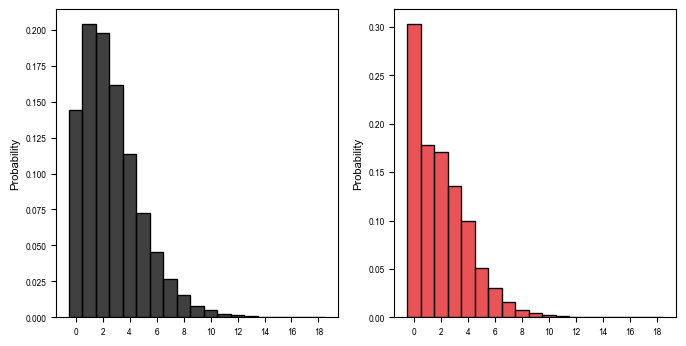

In [409]:
min_bcs_per_cell = 3

plt.figure(figsize=(8,4))
# plt.suptitle(f'Number of barcodes per cell (threshold={threshold})')
ax = plt.subplot(1,2,1)

# plot distribution of number of barcodes (above some threshold) in each cell
sns.histplot((downsampled_df >= min_bcs_per_cell).sum(axis=1),bins=range(20),stat='probability',ax=ax,color='k')
plt.xticks(np.arange(0.5,20.5,2),range(0,20,2))

ax = plt.subplot(1,2,2)
sns.histplot((in_vivo_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1),bins=range(20),stat='probability',ax=ax,color=colors[2])
plt.xticks(np.arange(0.5,20.5,2),range(0,20,2))

Downsampled pre-injection expectation: 3.1307940460693873 In vivo: 2.895207857469164


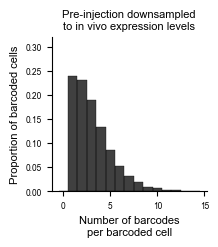

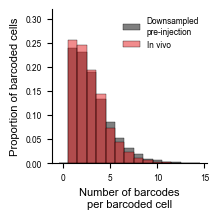

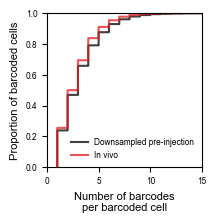

In [410]:
# ok now do the same as above but instead we're going to exclude all cells with zero transcripts
# this is because some of the in vivo cells are mouse cells, skewing the distribution

plt.figure(figsize=(2,2))
ax = plt.gca()
sns.despine()
plt.title('Pre-injection downsampled\nto in vivo expression levels')

downsampled_counts = (downsampled_df >= min_bcs_per_cell).sum(axis=1)
downsampled_counts_masked = np.ma.masked_where(downsampled_counts == 0, downsampled_counts)

# np.ma.masked_where(np.isclose(a, 0), a)

# plot distribution of number of barcodes (above some threshold) in each cell
sns.histplot(downsampled_counts_masked,bins=range(16),stat='probability',ax=ax,color='k',edgecolor='k',linewidth=0.25)
plt.xticks(np.arange(0.5,16.5,5),range(0,16,5),)
# plt.xticks(np.arange(0.5,20.5,2),range(0,20,2))
plt.ylim(0,0.32)
plt.xlabel('Number of barcodes\nper barcoded cell')
plt.ylabel('Proportion of barcoded cells')

# plt.savefig('../graphs/downsampled_pre-injection_barcodes_per_barcodedcell.pdf',bbox_inches='tight',transparent=True)


plt.figure(figsize=(2,2))

ax = plt.gca()
sns.despine()
in_vivo_counts = (in_vivo_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)
in_vivo_counts_masked = np.ma.masked_where(in_vivo_counts == 0, in_vivo_counts)

sns.histplot(downsampled_counts_masked,bins=range(16),stat='probability',
             ax=ax,color='k',edgecolor='k',linewidth=0.25,alpha=0.5,label='Downsampled\npre-injection')
sns.histplot(in_vivo_counts_masked,bins=range(16),stat='probability',
             ax=ax,color=colors[2],edgecolor='k',linewidth=0.25,alpha=0.5,label='In vivo')
plt.xticks(np.arange(0.5,16.5,5),range(0,16,5),)
plt.ylim(0,0.32)
plt.xlabel('Number of barcodes\nper barcoded cell')
plt.ylabel('Proportion of barcoded cells')

# plt.axvline(np.mean(downsampled_counts_masked.compressed()), color='k', linestyle='-', linewidth=1)
# plt.axvline(np.mean(in_vivo_counts_masked.compressed()), color=colors[2], linestyle='-', linewidth=1)
plt.legend(frameon=False)

# conduct T-test on means
print('Downsampled pre-injection expectation:',np.mean(downsampled_counts_masked.compressed()), 'In vivo:',np.mean(in_vivo_counts_masked.compressed()))
t_stat, p_value = scipy.stats.ttest_ind(downsampled_counts_masked.compressed(), in_vivo_counts_masked.compressed())
# plt.title(f'T-test: statistic={t_stat:.3f}, p-value={p_value:.3e}')

# plt.savefig('../graphs/downsampled_pre-injection_vs_in_vivo_barcodes_per_barcodedcell.pdf',bbox_inches='tight',transparent=True)


plt.figure(figsize=(2,2))

sns.ecdfplot(downsampled_counts_masked,stat='proportion',alpha=0.75,label='Downsampled pre-injection',color='k')
sns.ecdfplot(in_vivo_counts_masked,stat='proportion',alpha=0.75,label='In vivo',color=colors[2])
plt.legend(frameon=False)

plt.xticks([0,5,10,15],[0,5,10,15])
plt.xlim(0,15)

plt.xlabel('Number of barcodes\nper barcoded cell')
plt.ylabel('Proportion of barcoded cells')

# plt.savefig('../graphs/downsampled_pre-injection_vs_in_vivo_barcodes_per_barcodedcell_ecdf.pdf',bbox_inches='tight',transparent=True)


# conduct T-test on means
# print('Downsampled in-vitro expectation:',np.mean(downsampled_counts_masked.compressed()), 'In vivo:',np.mean(in_vivo_counts_masked.compressed()))
t_stat, p_value = scipy.stats.ttest_ind(downsampled_counts_masked.compressed(), in_vivo_counts_masked.compressed())
# plt.title(f'T-test: statistic={t_stat:.3f}, p-value={p_value:.3e}')
    

In [190]:
in_vivo_scrambled_df[tools.barcode_cols].sample(frac=1, axis=0, random_state=42)

,bc_001,bc_002,bc_003,bc_004,bc_005,bc_006,bc_007,bc_008,bc_009,bc_010,...,bc_087,bc_088,bc_089,bc_090,bc_091,bc_092,bc_093,bc_094,bc_095,bc_096
238194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139607,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
4044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0
259178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131932,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
in_vivo_df.copy()[tools.barcode_cols]

,bc_001,bc_002,bc_003,bc_004,bc_005,bc_006,bc_007,bc_008,bc_009,bc_010,...,bc_087,bc_088,bc_089,bc_090,bc_091,bc_092,bc_093,bc_094,bc_095,bc_096
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314148,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314151,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3.3087587290952665 2.3144238599720266
T-test: statistic=131.271, p-value=0.000e+00


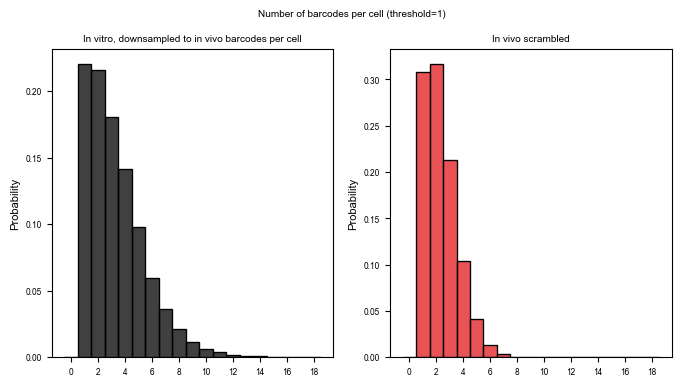

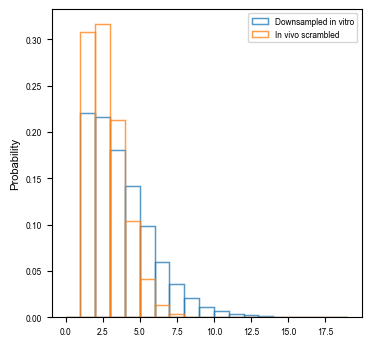

In [365]:
# ok to have a better apples to apples comparison, we actually need to scramble the barcode columns in the in vivo data

# in_vivo_scrambled_df = in_vivo_df.copy()
# # shuffle the barcode columns in the in vivo data
# in_vivo_scrambled_df[tools.barcode_cols] = in_vivo_scrambled_df[tools.barcode_cols].sample(frac=1, axis=0, random_state=42)
np.random.seed(42)

in_vivo_scrambled_df = in_vivo_df.copy()[tools.barcode_cols]
in_vivo_scrambled_df = in_vivo_scrambled_df.apply(lambda x: x.sample(frac=1).values)
# in_vivo_df[tools.barcode_cols].sample(frac=1, axis=0, random_state=42)
# now plot the distribution of barcodes per cell in the scrambled in vivo data



plt.figure(figsize=(8,4))
plt.suptitle(f'Number of barcodes per cell (threshold={threshold})')
ax = plt.subplot(1,2,1)
plt.title('In vitro, downsampled to in vivo barcodes per cell')

downsampled_counts = (downsampled_df >= min_bcs_per_cell).sum(axis=1)
downsampled_counts_masked = np.ma.masked_where(downsampled_counts == 0, downsampled_counts)

# np.ma.masked_where(np.isclose(a, 0), a)

# plot distribution of number of barcodes (above some threshold) in each cell
sns.histplot(downsampled_counts_masked,bins=range(20),stat='probability',ax=ax,color='k')
plt.xticks(np.arange(0.5,20.5,2),range(0,20,2))

in_vivo_counts = (in_vivo_scrambled_df[tools.barcode_cols] >= min_bcs_per_cell).sum(axis=1)
in_vivo_counts_masked = np.ma.masked_where(in_vivo_counts == 0, in_vivo_counts)

ax = plt.subplot(1,2,2)
plt.title('In vivo scrambled')
sns.histplot(in_vivo_counts_masked,bins=range(20),stat='probability',ax=ax,color=colors[2])
plt.xticks(np.arange(0.5,20.5,2),range(0,20,2))

plt.figure(figsize=(4,4))

sns.histplot(downsampled_counts_masked,bins=range(20),stat='probability',alpha=0.75,fill=False,label='Downsampled in vitro')
sns.histplot(in_vivo_counts_masked,bins=range(20),stat='probability',alpha=0.75,fill=False,label='In vivo scrambled')
plt.legend()

# conduct T-test on means
print(np.mean(downsampled_counts_masked.compressed()), np.mean(in_vivo_counts_masked.compressed()))
t_stat, p_value = scipy.stats.ttest_ind(downsampled_counts_masked.compressed(), in_vivo_counts_masked.compressed())
print(f'T-test: statistic={t_stat:.3f}, p-value={p_value:.3e}')
    
    

In [92]:
in_vivo_df[tools.barcode_cols].sample(frac=1, axis=0, random_state=42).sum(axis=0)

bc_001    346647.0
bc_002     80468.0
bc_003     98231.0
bc_004    112518.0
bc_005     32020.0
            ...   
bc_092    190394.0
bc_093    165004.0
bc_094     69128.0
bc_095    163584.0
bc_096     29896.0
Length: 96, dtype: float64

In [91]:
in_vivo_df[tools.barcode_cols].sum(axis=0)

bc_001    346647.0
bc_002     80468.0
bc_003     98231.0
bc_004    112518.0
bc_005     32020.0
            ...   
bc_092    190394.0
bc_093    165004.0
bc_094     69128.0
bc_095    163584.0
bc_096     29896.0
Length: 96, dtype: float64

In [129]:
in_vitro_df.groupby('roi')['bc_cluster'].nunique().sum()

10929

In [374]:

# get number of nunique bc_cluster for each roi in the in_vivo_df
in_vivo_df.groupby('roi')['bc_cluster'].nunique()

print(in_vivo_df.groupby('roi')['bc_cluster'].nunique())
print(in_vivo_df.groupby('roi')['bc_cluster'].nunique().sum())

# # only include bc_clusters with at least 10 cells
# in_vivo_df_here['bc_cluster_n_cells'] = in_vivo_df.groupby('bc_cluster')['object_id'].transform('count')
# in_vivo_df_here = in_vivo_df[in_vivo_df['bc_cluster_n_cells'] >= 10]
# # get number of nunique bc_cluster for each roi in the in_vivo_df
# in_vivo_df.groupby('roi')['bc_cluster'].nunique()

roi
roi_1          2411
roi_2          3424
roi_3          1545
run2_roi_2     3562
run2_roi_3    11850
Name: bc_cluster, dtype: int64
22792


In [123]:


in_vivo_df.groupby('roi')['bc_cluster'].value_counts() > 10

# get number of nunique bc_cluster for each roi in the in_vivo_df


roi         bc_cluster
roi_1       444.0          True
            269.0          True
            39.0           True
            474.0          True
            356.0          True
                          ...  
run2_roi_3  11845.0       False
            11846.0       False
            11847.0       False
            11848.0       False
            11849.0       False
Name: bc_cluster, Length: 22792, dtype: bool

In [127]:
result = (in_vivo_df.groupby('roi')['bc_cluster']
          .value_counts()
          .loc[lambda x: x >= 10]
          .groupby('roi')
          .size())

print(result)
print()

roi
roi_1         272
roi_2         327
roi_3         220
run2_roi_2    362
run2_roi_3    561
Name: bc_cluster, dtype: int64


In [137]:
## simulate the distribution of detected barcodes per cell

n_replicates = 10

# moi_list = np.linspace(1,5,9) # list of target mois to simulate
# moi_list = [0.,0.75,1.5,3,6]
moi_list = np.logspace(np.log2(0.5),np.log2(5),num=10,base=2)
thresh_list = [0,1,2] # list of number of unique barcodes in threshold
n_barcodes = 96
n_cells = 100000

In [135]:
frac_passing_out = {}
collision_out = {}

results = {}

for t,target_moi in enumerate(moi_list):
    
    frac_passing_out[target_moi] = {}
    collision_out[target_moi] = {}
    results[target_moi] = {}
    
    for rep in range(n_replicates):

        integration_list = []

        for c in range(n_cells):
            n_integrations = np.random.poisson(target_moi)
            these_integrations = '_'.join([str(x) for x in sorted(np.unique(np.random.choice(range(n_barcodes),n_integrations)))])
            integration_list.append(these_integrations)

        uniques,counts = np.unique(integration_list,return_counts=True)
        uniques = uniques[np.argsort(counts)[::-1]]
        counts = counts[np.argsort(counts)[::-1]]
        n_unique_bcs = np.asarray([u.count('_')+1 if u != '' else 0 for u in uniques ])
        results[target_moi][rep] = {u:count for u,count in zip(uniques,counts)}

distribution = {}
for t,target_moi in enumerate(moi_list):
    distribution[target_moi] = {}
    for rep in range(n_replicates):

        distribution[target_moi][rep] = np.zeros(n_barcodes+1)
        for combo, count in results[target_moi][rep].items():
            if combo == '':
                distribution[target_moi][rep][0] += count
            else:
                distribution[target_moi][rep][combo.count('_')+1] += count
        # results[target_moi][rep]



#         for u,uni_thresh in enumerate(thresh_list):
            
#             if rep == 0:
#                 frac_passing_out[target_moi][uni_thresh] = []
#                 collision_out[target_moi][uni_thresh] = []
            
# #             frac_passing_out[target_moi][uni_thresh].append(len(counts[np.where(n_unique_bcs > uni_thresh)[0]])/n_cells)
#             frac_passing_out[target_moi][uni_thresh].append(len(counts[np.where(n_unique_bcs > uni_thresh)[0]])/len(counts))
#             collision_out[target_moi][uni_thresh].append(sum(counts[np.where(n_unique_bcs > uni_thresh)[0]]>1)/len(counts[np.where(n_unique_bcs > uni_thresh)[0]]))

        

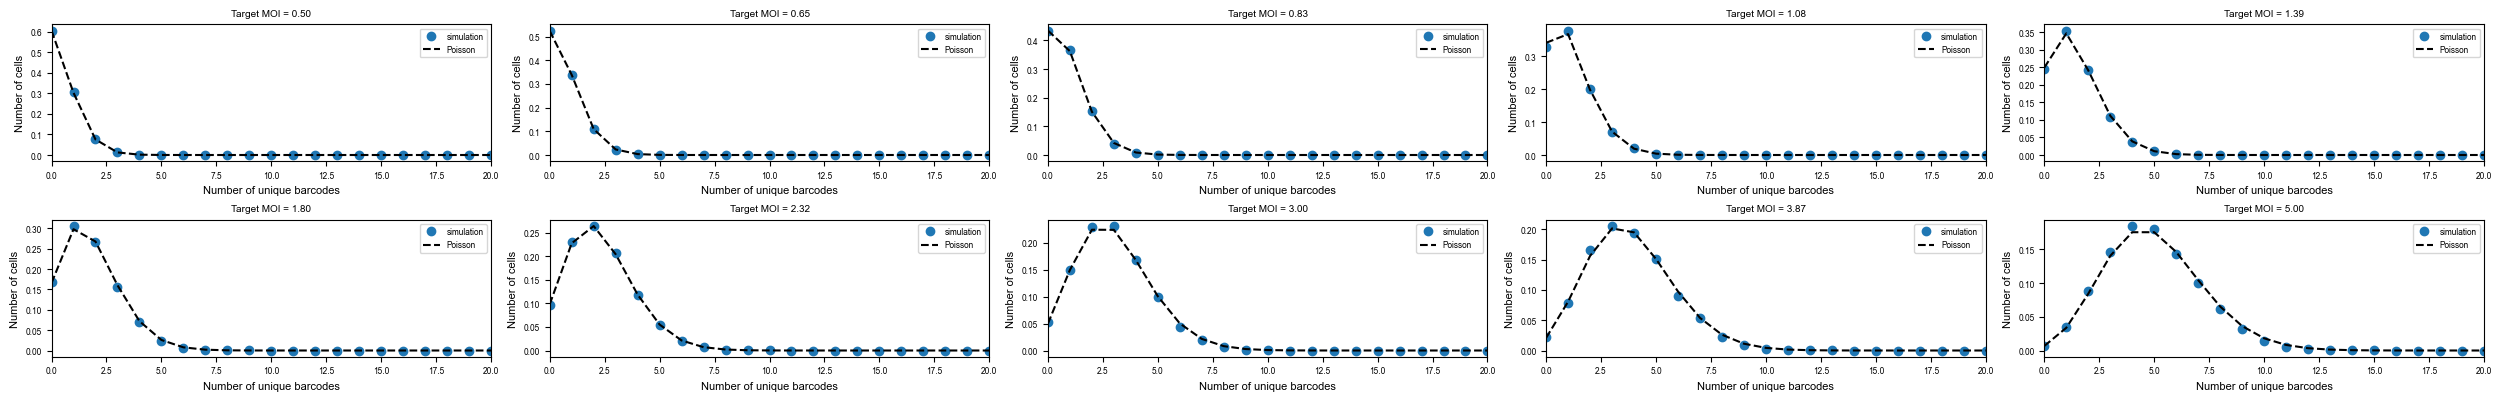

In [136]:
fig = plt.figure(figsize=(5*5,2*2))

for t,target_moi in enumerate(moi_list):
    fig.add_subplot(2,5,t+1)
    # for rep in range(n_replicates):
    plt.plot(distribution[target_moi][rep]/n_cells,marker='o',label='simulation',linestyle='')

    # plot the poisson distribution as null comparison

    plt.plot(scipy.stats.poisson.pmf(range(n_barcodes+1),target_moi),label='Poisson',color='black',linestyle='--')

    plt.xlabel('Number of unique barcodes')
    plt.ylabel('Number of cells')
    plt.title('Target MOI = %.2f'%target_moi)
    plt.xlim(0,20)
    plt.legend()
    plt.tight_layout()
    # plt.show()